In [2]:
import pickle
import torch
import matplotlib.pyplot as plt

/var/folders/kg/8rw13j991l36qb68sz4mp8qc0000gn/T/ipykernel_43964/4146026253.py:73: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_model_0[:, 0], X_model_0[:, 1], cmap='Set1')
/var/folders/kg/8rw13j991l36qb68sz4mp8qc0000gn/T/ipykernel_43964/4146026253.py:74: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_model_1[:, 0], X_model_1[:, 1], cmap='Set1')


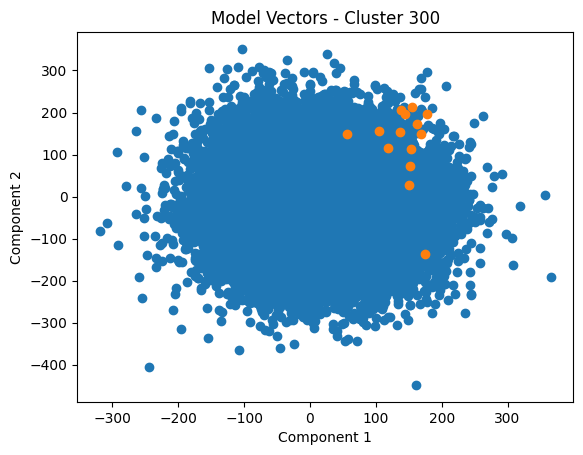

/var/folders/kg/8rw13j991l36qb68sz4mp8qc0000gn/T/ipykernel_43964/4146026253.py:83: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_glove_0[:, 0], X_glove_0[:, 1], cmap='Set1')
/var/folders/kg/8rw13j991l36qb68sz4mp8qc0000gn/T/ipykernel_43964/4146026253.py:84: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X_glove_1[:, 0], X_glove_1[:, 1], cmap='Set1')


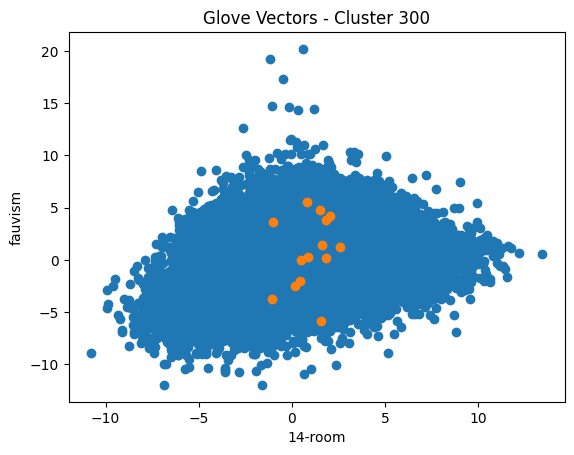

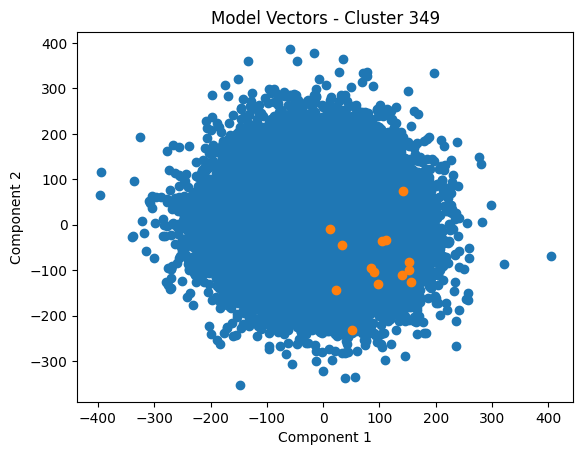

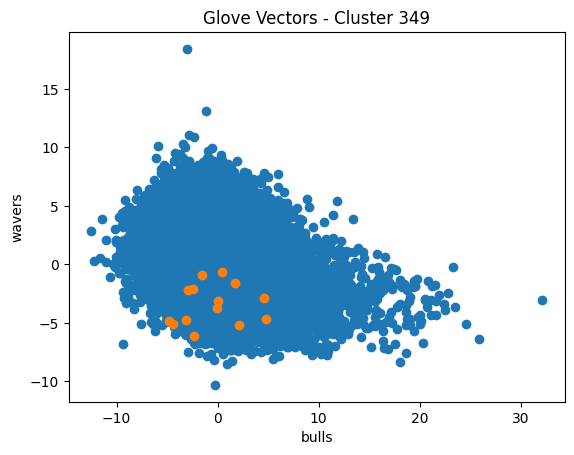

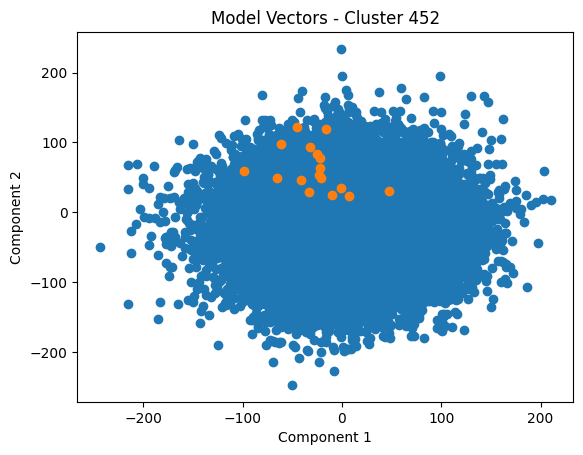

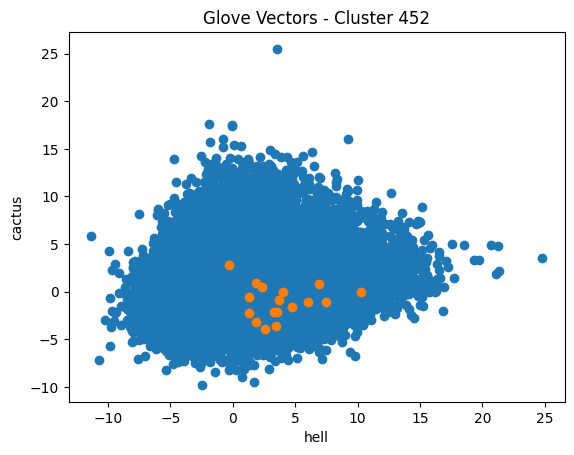

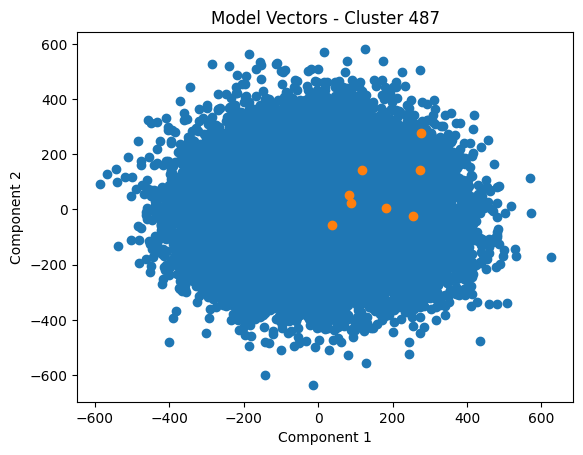

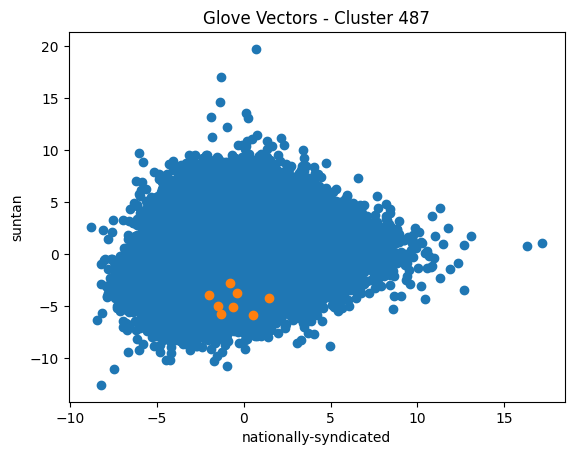

In [12]:
# Load the data about the clusters
_, data = pickle.load(open("./glove/kmeans_clusters_500_100d.pkl", "rb"))

# Check if GPU(s) are available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

save_dir = "./projectors_100d/"

X, labels = None, None
for key in data.keys():
    if X is None:
        X = torch.Tensor(data[key])
        labels = torch.reshape(torch.Tensor([key] * len(data[key])), (-1, 1))
    else:
        X = torch.cat([X, torch.Tensor(data[key])])
        temp = torch.reshape(torch.Tensor([key] * len(data[key])), (-1, 1))
        labels = torch.cat([labels, temp])

# Create the set of unique labels
targets = [x.item() for x in labels]
unique_labels = list(set(targets))

unique_labels = [300, 349, 452, 487]

for j in unique_labels:
    glove_vectors = []
    model_vectors = []  
    words = []
    
    # One hot the labels
    targets = [1 if x.item() == j else 0 for x in labels]
    
    explanations = pickle.load(open(save_dir + f"closest_words-{int(j)}.pkl", "rb"))
    for exp in explanations.values():
        glove_vectors.append(exp["glove vector"])
        model_vectors.append(exp["produced vector"])
        words.append(exp["word"])
        
    # Model vectors is a k length list of d dimensional vectors
    # Turn it into a k x d tensor
    model_vectors = torch.Tensor(model_vectors)
    glove_vectors = torch.Tensor(glove_vectors)
    
    glove_vectors = (glove_vectors.reshape(glove_vectors.shape[0], -1))
    
    # y = model_vectors.T
    # model_vector_projection_matrix = y @ (y.T @ y).inverse() @ y.T
    # 
    # y = glove_vectors.T
    # glove_vector_projection_matrix = y @ (y.T @ y).inverse() @ y.T
    # 
    # Project X
    # X_model = model_vector_projection_matrix @ X.T
    # X_glove = glove_vector_projection_matrix @ X.T
    
    # X_model = X_model.T
    # X_glove = X_glove.T
    
    # Reduce vectors in X_model into combinations of the model_vectors
    X_model = X @ model_vectors.T
    # Get all the vectors with the same label
    X_model_1 = X_model[torch.Tensor(targets) == 1]
    X_model_0 = X_model[torch.Tensor(targets) == 0]
    
    # Reduce vectors in X_glove into combinations of the glove_vectors
    X_glove = X @ glove_vectors.T
    # Get all the vectors with the same label
    X_glove_1 = X_glove[torch.Tensor(targets) == 1]
    X_glove_0 = X_glove[torch.Tensor(targets) == 0]
    
    # Plot the reduced vectors
    fig, ax = plt.subplots()
    ax.scatter(X_model_0[:, 0], X_model_0[:, 1], cmap='Set1')
    ax.scatter(X_model_1[:, 0], X_model_1[:, 1], cmap='Set1')
    # Set the axes labels
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_title(f"Model Vectors - Cluster {int(j)}")
    plt.savefig(save_dir + f"projector-{int(j)}-model.png", dpi=500)
    plt.show()
    
    fig, ax = plt.subplots()
    ax.scatter(X_glove_0[:, 0], X_glove_0[:, 1], cmap='Set1')
    ax.scatter(X_glove_1[:, 0], X_glove_1[:, 1], cmap='Set1')
    # Set the axes labels
    ax.set_xlabel(words[0])
    ax.set_ylabel(words[1])
    ax.set_title(f"Glove Vectors - Cluster {int(j)}")
    plt.savefig(save_dir + f"projector-{int(j)}-glove.png", dpi=500)
    plt.show()
    

In [25]:
labels = [x for x in range(0, 20)]

# Get the vectors for each label
words, vectors = pickle.load(open("./glove/gm_clusters_500.pkl", "rb"))

for label in labels:
    # Find the mean of vectors[label]
    mean = torch.mean(torch.Tensor(vectors[label]), dim=0)
    
    # Find the distance between the mean and all the vectors
    distances = []
    for vector in vectors[label]:
        distances.append(torch.dist(mean, torch.Tensor(vector)))
    
    # Get the indices of the closest vectors
    indices = torch.argsort(torch.Tensor(distances))
    
    # Get the closest vectors
    closest_words = [words[label][i] for i in indices[:5]]
    
    print(f"Closest words to cluster {label}: {closest_words}")

Closest words to cluster 0: ['menstruation', 'childbirth', 'maturation', 'metamorphosis', 'hormonal']
Closest words to cluster 1: ['pilling', 'tootle', 'lippy', 'dangler', 'gayer']
Closest words to cluster 2: ['insuring', 'debtors', 'compensating', 'originators', 'prepay']
Closest words to cluster 3: ['givebacks', 'nonunion', 'retirees', 'pensioners', 'janitors']
Closest words to cluster 4: ['kilogram', 'ton', 'weighs', 'weighing', '½']
Closest words to cluster 5: ['wannabes', 'bevy', 'lightweights', 'celebs', 'coifs']
Closest words to cluster 6: ['separating', 'separates', 'stretching', 'extends', 'stretches']
Closest words to cluster 7: ['precludes', 'repudiating', 'negating', 'precluding', 'validating']
Closest words to cluster 8: ['suspecting', 'credibly', 'deceived', 'duped', 'legitimately']
Closest words to cluster 9: ['antimatter', 'impurity', 'malefic', 'extractors', 'gaseous']
Closest words to cluster 10: ['functioned', 'bypassed', 'superseded', 'reconfigured', 'supplanted']
C